In [1]:
import os, json

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfk = tf.keras
tfl = tf.keras.layers
tfs = tf.summary

import numpy as np

from tqdm import tqdm_notebook as tqdm

from architectures import ManifoldVAE, MeasureVAE
from train import config, optimizers, mnist_parse_fn, mnist_input_fn

import matplotlib.pyplot as plt

import tensorflow_datasets as tfds


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



ModuleNotFoundError: No module named 'tensorflow_datasets'

In [2]:
# ==========================================================================
# Create model
# ==========================================================================

MODEL_DIR = "/tmp/celeba_2stage"

with tf.device("CPU:0"):
    manifold_vae = ManifoldVAE(latent_dim=128)
    measure_vae = MeasureVAE(latent_dim=128)

    manifold_optimizer = optimizers[config["optimizer"]](config["learning_rate"])
    measure_optimizer = optimizers[config["optimizer"]](config["learning_rate"])

    # ==========================================================================
    # Checkpoints
    # ==========================================================================

    # Create checkpoint and its manager
    manifold_ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=manifold_optimizer, net=manifold_vae)
    manifold_manager = tf.train.CheckpointManager(manifold_ckpt, MODEL_DIR + "/manifold_checkpoints", max_to_keep=3)

    measure_ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=measure_optimizer, net=measure_vae)
    measure_manager = tf.train.CheckpointManager(measure_ckpt, MODEL_DIR + "/measure_checkpoints", max_to_keep=3)

    # Attempt to restore model
    manifold_ckpt.restore(manifold_manager.latest_checkpoint)
    if manifold_manager.latest_checkpoint:
        print("Restored from {}".format(manifold_manager.latest_checkpoint))
    else:
        print("Initializing manifold VAE from scratch.")

    # Attempt to restore model
    measure_ckpt.restore(measure_manager.latest_checkpoint)
    if measure_manager.latest_checkpoint:
        print("Restored from {}".format(measure_manager.latest_checkpoint))
    else:
        print("Initializing Measure VAE from scratch.")

Restored from /tmp/celeba_2stage/manifold_checkpoints/ckpt-1934
Initializing Measure VAE from scratch.


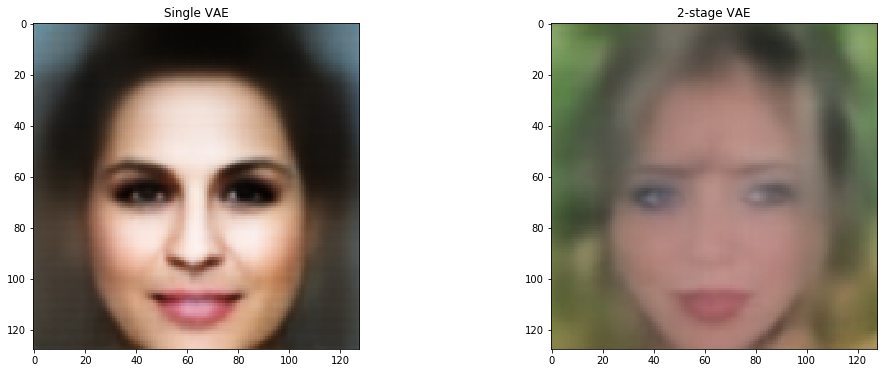

In [5]:
with tf.device("CPU:0"):

    # idx = 1000

    # im = eval_data[idx:idx + 1]
    # z_1 = manifold_vae.encoder(mnist_parse_fn(im), training=False)

    #z_2 = measure_vae.encoder(z_1)

    manifold_vae(tf.zeros((1, 128, 128, 3)))
    measure_vae(tf.zeros((1, 128)))

    z_ = manifold_vae.prior.sample()
    z_ = z_[tf.newaxis, ...]
    rec_im_ = manifold_vae.decoder(z_)


    z_2 = measure_vae.prior.sample()
    z_2 = z_2[tf.newaxis, ...]
    z = measure_vae.decoder(z_2)

    rec_im = manifold_vae.decoder(z, training=False)


    plt.figure(figsize=(17, 6))
    plt.subplot(121)
    plt.title("Single VAE")
    plt.imshow(tf.squeeze(rec_im_))

    plt.subplot(122)
    plt.title("2-stage VAE")
    plt.imshow(tf.squeeze(rec_im))

    plt.show()

In [12]:
def parse_celeba(datum):
    return tf.cast(datum["image"][45:-45, 25:-25, :], tf.float32) / 255.

def load_celeba_data(train=True, data_dir="/tmp/tensorflow_datasets", batch_size=64, shuffle_buffer=2048):
    
    data, info = tfds.load("celeb_a", with_info=True, as_supervised=False, data_dir=data_dir)
    train_data, test_data = data['train'], data['test']
    
    if train:
        celeba = train_data
    else:
        celeba = test_data
    
    celeba = celeba.map(parse_celeba).repeat().shuffle(shuffle_buffer).batch(batch_size)

    celeba = celeba.prefetch(tf.data.experimental.AUTOTUNE)
    
    return celeba

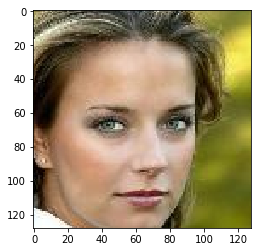

In [13]:
ds = load_celeba_data(train=True)

for d in ds.take(1):
    
    plt.imshow(d[0])

In [38]:
help(tf.image.resize)

Help on function resize_images_v2 in module tensorflow.python.ops.image_ops_impl:

resize_images_v2(images, size, method='bilinear', preserve_aspect_ratio=False, antialias=False, name=None)
    Resize `images` to `size` using the specified `method`.
    
    Resized images will be distorted if their original aspect ratio is not
    the same as `size`.  To avoid distortions see
    `tf.image.resize_with_pad`.
    
    When 'antialias' is true, the sampling filter will anti-alias the input image
    as well as interpolate.   When downsampling an image with [anti-aliasing](
    https://en.wikipedia.org/wiki/Spatial_anti-aliasing) the sampling filter
    kernel is scaled in order to properly anti-alias the input image signal.
    'antialias' has no effect when upsampling an image.
    
    *   <b>`bilinear`</b>: [Bilinear interpolation.](
      https://en.wikipedia.org/wiki/Bilinear_interpolation) If 'antialias' is
      true, becomes a hat/tent filter function with radius 1 when downsampl